# Attribute Information

<ol>
    <li>age</li>
    <li>job : type of job</li>
    <li>marital : marital status</li>
    <li>education</li>
    <li>default: has credit in default?</li>
    <li>housing: has housing loan?</li>
    <li>loan: has personal loan?</li>
    <li>balance in account</li>
    <li>contact: contact communication type</li>
    <li>month: last contact month of year</li>
    <li>day: last contact day of the month</li>
    <li>duration: last contact duration, in seconds</li>
    <li>campaign: number of contacts performed during this campaign and for this client</li>
    <li>pdays: number of days that passed by after the client was last contacted from a previous campaign</li>
    <li>previous: number of contacts performed before this campaign and for this client</li>
    <li>poutcome: outcome of the previous marketing campaign</li>
    <li>Output variable ('Target'): has the client subscribed a term deposit?</li>
</ol>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, recall_score, classification_report, accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
import graphviz
from IPython.display import display
from sklearn import tree

In [306]:
bank_data = pd.read_csv('bank-full.csv')
bank_data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome Target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no

In [307]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [308]:
bank_data.shape

(45211, 17)

In [309]:
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

In [310]:
bank_data[bank_data.duplicated()].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

In [311]:
bank_data['day'].unique()

array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
       29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31])

In [205]:
bank_data[bank_data['pdays']==999]

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, Target]
Index: []

In [206]:
# pdays cannot be negative so lets treat the pdays column
bank_data['pdays'] = bank_data['pdays'].abs()
bank_data[bank_data['pdays']<0]

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, Target]
Index: []

In [207]:
bank_data_description = bank_data.describe().transpose()
bank_data_description['median'] = bank_data.median()
bank_data_description['IQR'] = bank_data.quantile(0.75) - bank_data.quantile(0.25)
bank_data_description['Skewness'] = bank_data.skew()
bank_data_description

count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
day       45211.0    15.806419     8.322476     1.0    8.0   16.0    21.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0   
pdays     45211.0    41.832563    99.456849     1.0    1.0    1.0     1.0   
previous  45211.0     0.580323     2.303441     0.0    0.0    0.0     0.0   

               max  median     IQR   Skewness  
age           95.0    39.0    15.0   0.684818  
balance   102127.0   448.0  1356.0   8.360308  
day           31.0    16.0    13.0   0.093079  
duration    4918.0   180.0   216.0   3.144318  
campaign      63.0     2.0     2.0   4.898650  
pdays        871.0     1.0     0.0   2.627828  
previous     275.0     0.0     0.0  41.846454

In [208]:
#get the list of categorical columns and numerical columns
def get_categorical_and_numerical_columns():
    cols = bank_data.columns
    numerical_columns = bank_data._get_numeric_data().columns
    categorical_columns = list(set(cols)- set(numerical_columns))
    return numerical_columns, categorical_columns
numerical_columns, categorical_columns = get_categorical_and_numerical_columns()

In [209]:
# Find the value counts of categorical columns
for col in categorical_columns:
    print(bank_data[col].value_counts())

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
no     44396
yes      815
Name: default, dtype: int64
no     39922
yes     5289
Name: Target, dtype: int64
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
yes    25130
no     20081
Name: housing, dtype: int64
no     37967
yes     7244
Name: loan, dtype: int64
unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64
married     27214
single      

# Insights

1. The data has less defaulters
2. We have less subscriptions for the term deposit. 88% of the people did not subscribed for term deposit
3. For almost 81% of the data we don't know the outcome of previous campaign
4. More than 50% of the people has secondary education
5. 83% of people doesn't have personal loan
6. Major mode of communication with the customers is by cellular phone

In [210]:
bank_data[bank_data['balance'] < 0]

age          job   marital  education default  balance housing loan  \
25      44       admin.   married  secondary      no     -372     yes   no   
28      46   management    single  secondary      no     -246     yes   no   
36      25  blue-collar   married  secondary      no       -7     yes   no   
37      53   technician   married  secondary      no       -3      no   no   
45      36       admin.    single    primary      no     -171     yes   no   
...    ...          ...       ...        ...     ...      ...     ...  ...   
44626   31     services    single  secondary      no     -205      no   no   
44629   28  blue-collar    single  secondary      no      -46     yes   no   
44836   33  blue-collar   married    primary      no     -195      no   no   
44908   48   management  divorced   tertiary      no     -130     yes   no   
44964   21  blue-collar    single    primary      no      -42      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
25      unknown    5   may       172         1      1         0  unknown   
28      unknown    5   may       255         2      1         0  unknown   
36      unknown    5   may       365         1      1         0  unknown   
37      unknown    5   may      1666         1      1         0  unknown   
45      unknown    5   may       242         1      1         0  unknown   
...         ...  ...   ...       ...       ...    ...       ...      ...   
44626  cellular    1   sep       481         1    579         1  failure   
44629  cellular    1   sep       199         1     92        14  success   
44836   unknown   20   sep         9         1      1         0  unknown   
44908  cellular   29   sep       110         2     61         9  failure   
44964   unknown   10   oct         5         1      1         0  unknown   

      Target  
25        no  
28        no  
36        no  
37        no  
45        no  
...      ...  
44626    yes  
44629    yes  
44836     no  
44908     no  
44964     no  

[3766 rows x 17 columns]

<h3> 'balance' column has negative values, I am not going to treat this column assuming that the bank allows overdraft </h3>

# Univariate Analysis

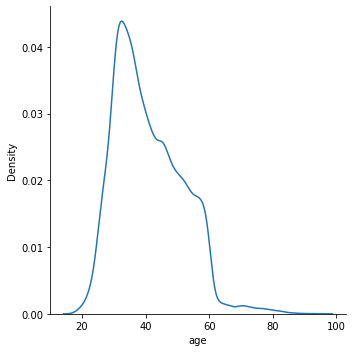

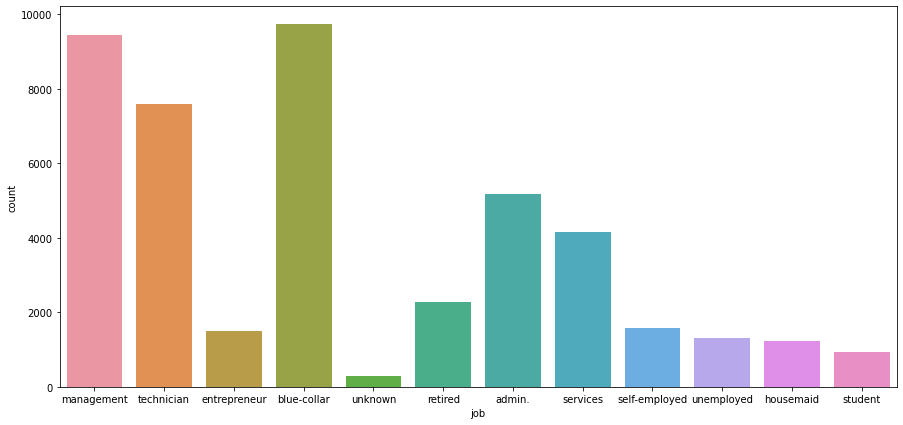

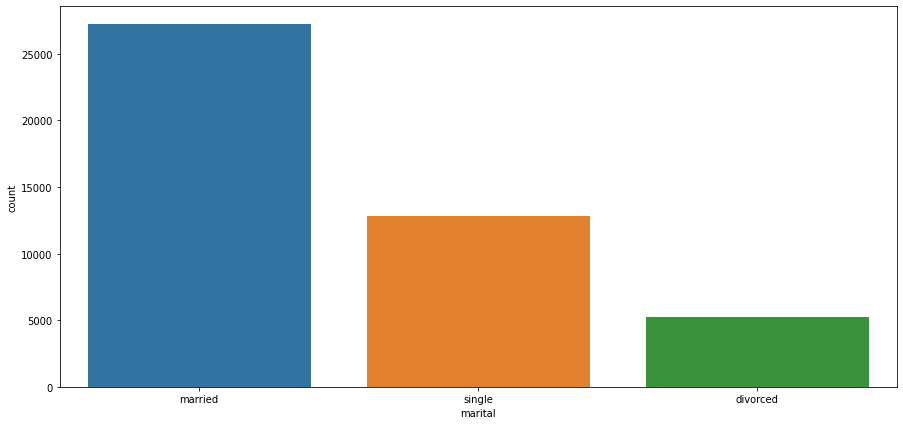

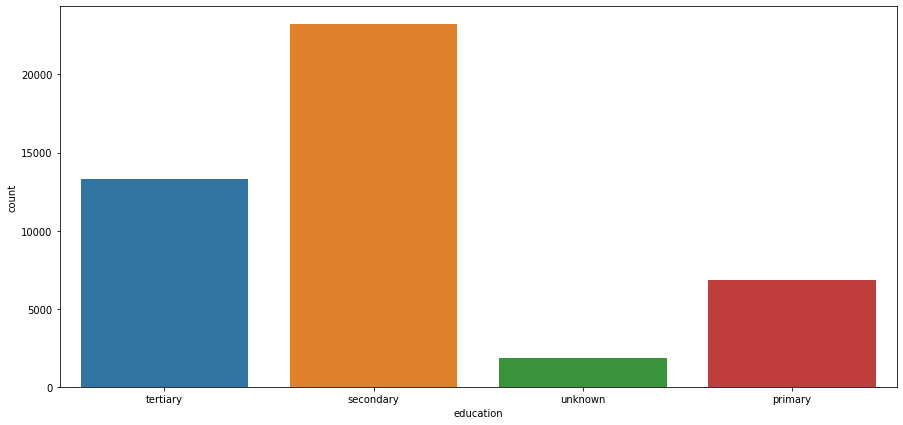

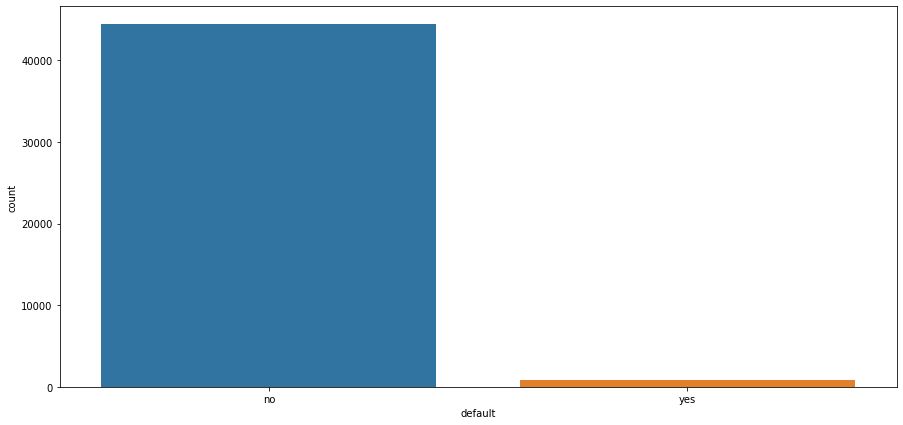

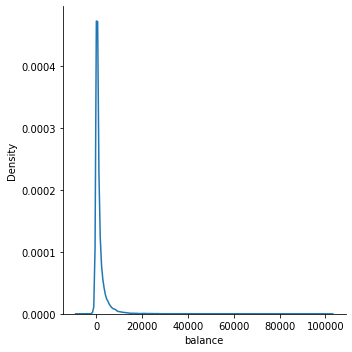

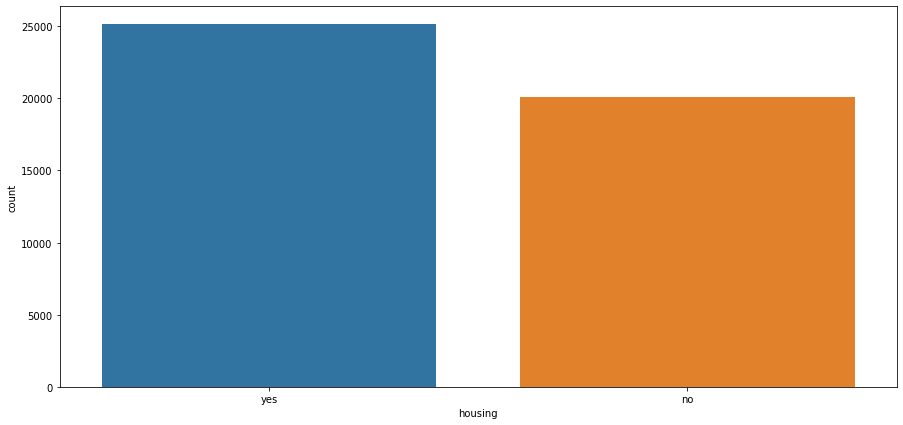

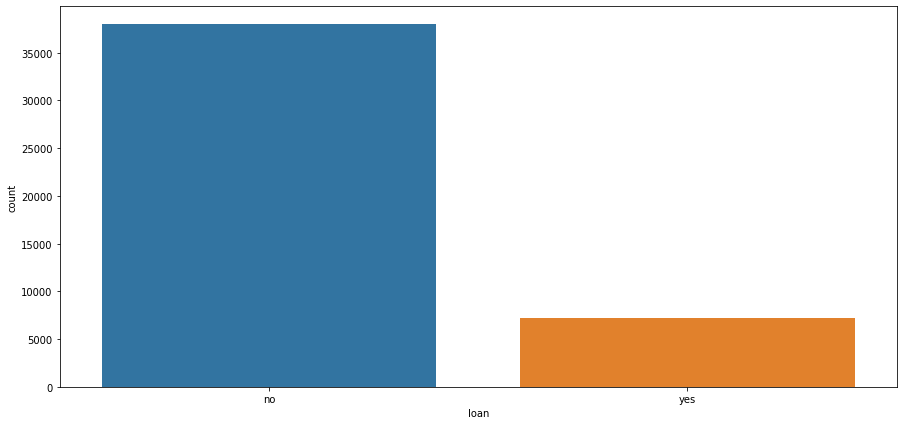

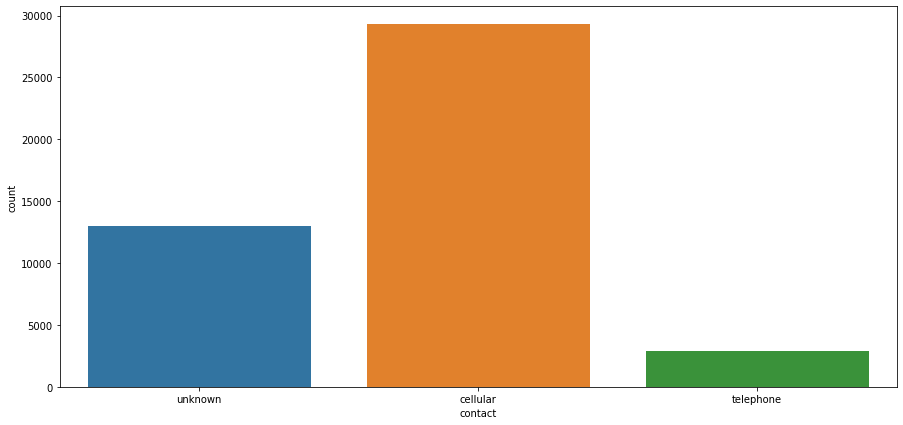

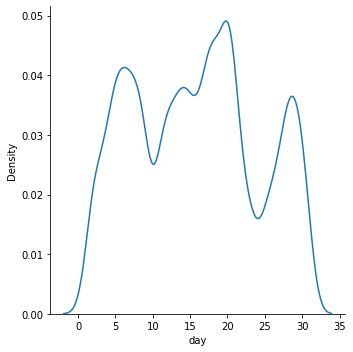

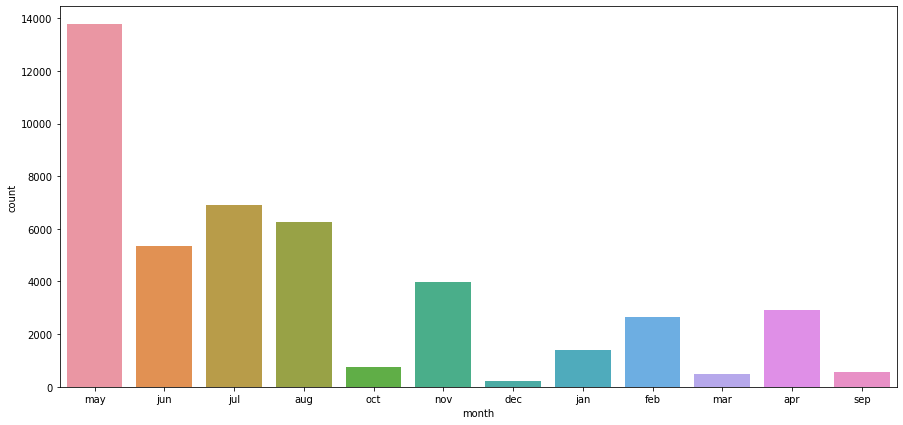

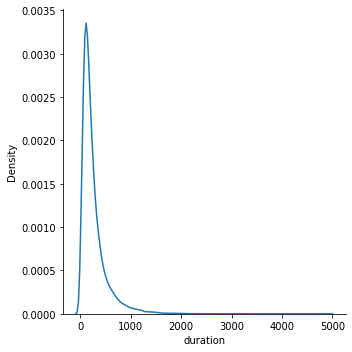

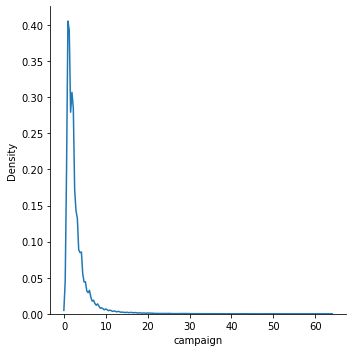

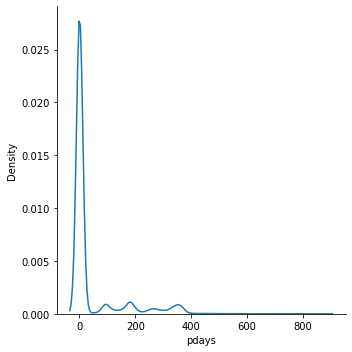

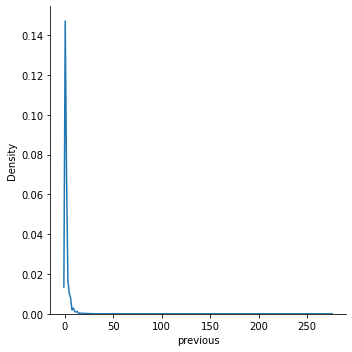

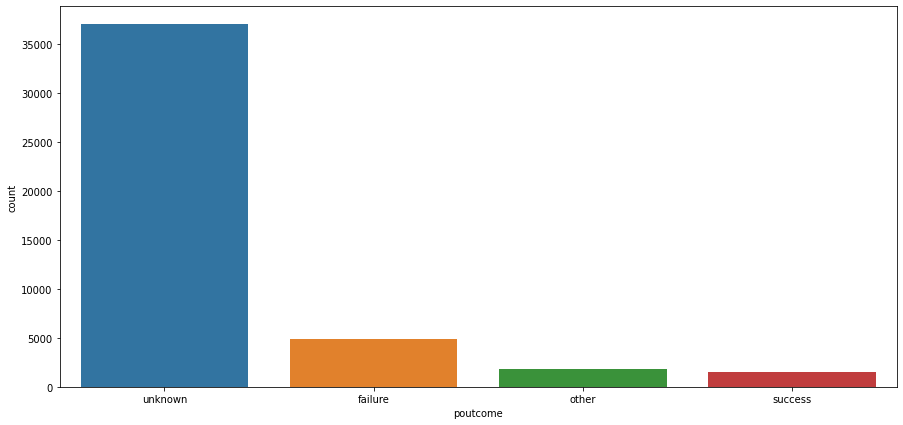

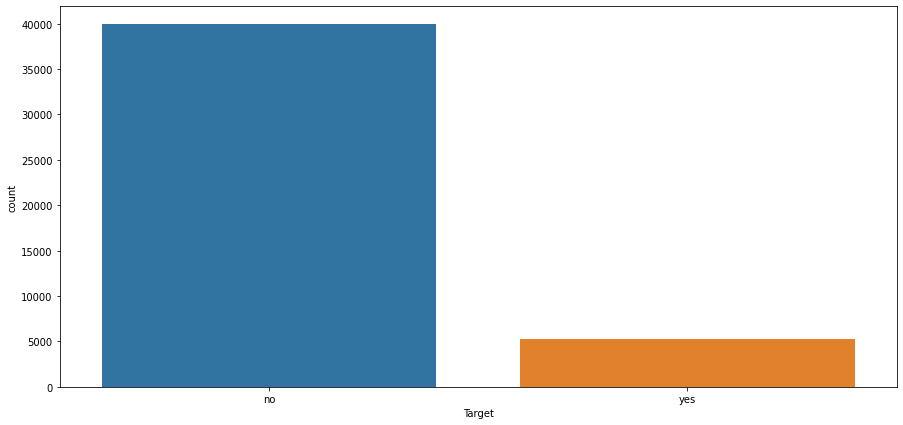

In [211]:
def plotgraphs(data):
    plt.rcParams['figure.figsize'] = (15,7)
    for col in data.columns:
        if col in numerical_columns:
            sns.displot(data[col], kind='kde')
        else:
            sns.countplot(data[col])
        plt.show()

plotgraphs(bank_data)

High number of people in management have subscribed for term deposit compared all other job types

In [212]:
#normalizing numerical data:
standardScaler = StandardScaler()
for col in numerical_columns:
  bank_data[col] = standardScaler.fit_transform(bank_data[[col]])
bank_data.head()

age           job  marital  education default   balance housing loan  \
0  1.606965    management  married   tertiary      no  0.256419     yes   no   
1  0.288529    technician   single  secondary      no -0.437895     yes   no   
2 -0.747384  entrepreneur  married  secondary      no -0.446762     yes  yes   
3  0.571051   blue-collar  married    unknown      no  0.047205     yes   no   
4 -0.747384       unknown   single    unknown      no -0.447091      no   no   

   contact       day month  duration  campaign    pdays  previous poutcome  \
0  unknown -1.298476   may  0.011016 -0.569351 -0.41056  -0.25194  unknown   
1  unknown -1.298476   may -0.416127 -0.569351 -0.41056  -0.25194  unknown   
2  unknown -1.298476   may -0.707361 -0.569351 -0.41056  -0.25194  unknown   
3  unknown -1.298476   may -0.645231 -0.569351 -0.41056  -0.25194  unknown   
4  unknown -1.298476   may -0.233620 -0.569351 -0.41056  -0.25194  unknown   

  Target  
0     no  
1     no  
2     no  
3     no  
4     no

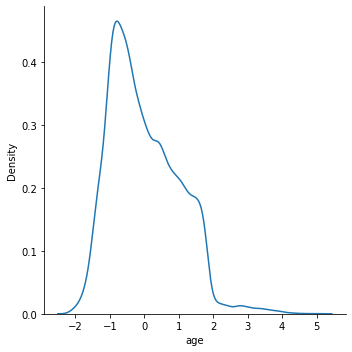

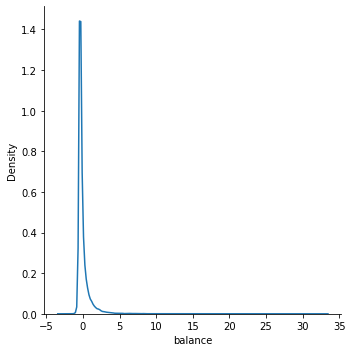

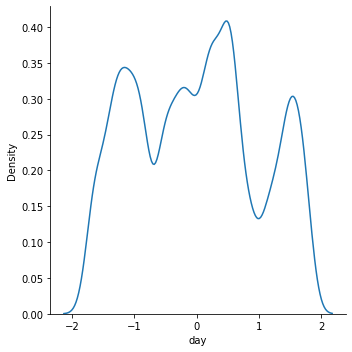

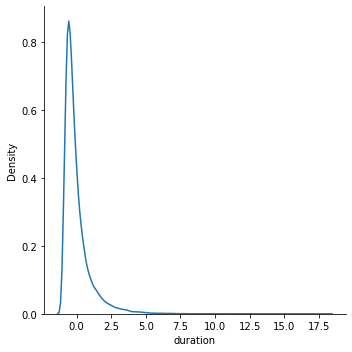

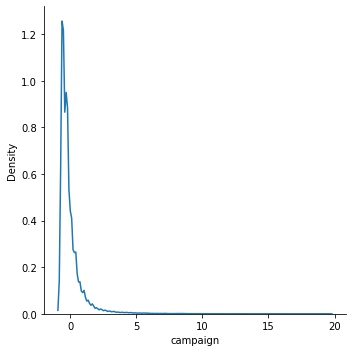

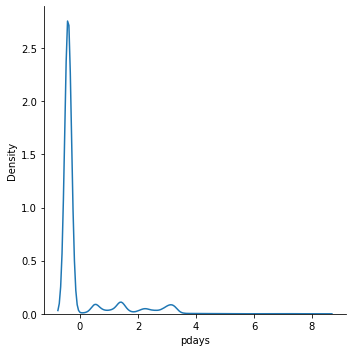

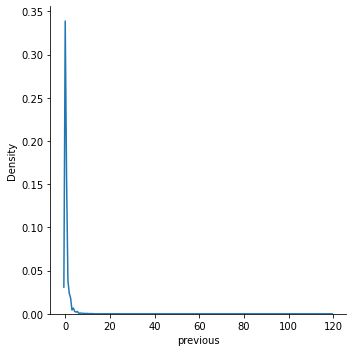

In [213]:
for col in numerical_columns:
    sns.displot(bank_data[col], kind='kde')
    plt.show()

In [214]:
#Identify outliers
IQR = bank_data_description['IQR']
Q1 = bank_data.quantile(0.25)
Q3 = bank_data.quantile(0.75)

outlier_row_index = np.where((bank_data< Q1 - 1.5 * IQR) | (bank_data > Q3 + 1.5* IQR))[0]
bank_data_outliers = bank_data.iloc[outlier_row_index, : ]
bank_data_outliers

age           job   marital  education default   balance housing  \
2626  -0.935732    technician   married  secondary      no -0.412605     yes   
2706   0.476877        admin.  divorced   tertiary      no  0.783888     yes   
2967  -0.370689    technician   married   tertiary     yes -0.447419     yes   
3044   0.947747    unemployed   married  secondary      no -0.307834     yes   
3079  -1.218254   blue-collar   married    primary      no -0.447419      no   
...         ...           ...       ...        ...     ...       ...     ...   
45204  3.019575       retired   married  secondary      no  0.488624      no   
45208  2.925401       retired   married  secondary      no  1.429593      no   
45208  2.925401       retired   married  secondary      no  1.429593      no   
45210 -0.370689  entrepreneur   married  secondary      no  0.528364      no   
45210 -0.370689  entrepreneur   married  secondary      no  0.528364      no   

      loan   contact       day month  duration  campaign     pdays  previous  \
2626    no   unknown -0.337213   may -0.610283  3.304133 -0.410560 -0.251940   
2706    no   unknown -0.337213   may -0.734543  5.240875 -0.410560 -0.251940   
2967    no   unknown -0.217055   may -0.641348  3.626923 -0.410560 -0.251940   
3044    no   unknown -0.217055   may  0.108094  3.626923 -0.410560 -0.251940   
3079    no   unknown -0.217055   may -0.936465  6.854826 -0.410560 -0.251940   
...    ...       ...       ...   ...       ...       ...       ...       ...   
45204   no  cellular  0.143418   nov  0.162458 -0.569351 -0.018426  3.221163   
45208   no  cellular  0.143418   nov  3.373797  0.721811  1.429454  1.050473   
45208   no  cellular  0.143418   nov  3.373797  0.721811  1.429454  1.050473   
45210   no  cellular  0.143418   nov  0.399328 -0.246560  1.469673  4.523577   
45210   no  cellular  0.143418   nov  0.399328 -0.246560  1.469673  4.523577   

      poutcome Target  
2626   unknown     no  
2706   unknown     no  
2967   unknown     no  
3044   unknown     no  
3079   unknown     no  
...        ...    ...  
45204  failure    yes  
45208  success    yes  
45208  success    yes  
45210    other     no  
45210    other     no  

[17339 rows x 17 columns]

In [215]:
def get_outliers(data):
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    return outliers
outliers = get_outliers(bank_data)
outliers

Target          0
age             0
balance         0
campaign      840
contact         0
day             0
default         0
duration        0
education       0
housing         0
job             0
loan            0
marital         0
month           0
pdays        8242
poutcome        0
previous     8257
dtype: int64

In [216]:
percentage_of_outliers = (outliers/len(bank_data)) * 100
percentage_of_outliers

Target        0.000000
age           0.000000
balance       0.000000
campaign      1.857955
contact       0.000000
day           0.000000
default       0.000000
duration      0.000000
education     0.000000
housing       0.000000
job           0.000000
loan          0.000000
marital       0.000000
month         0.000000
pdays        18.230077
poutcome      0.000000
previous     18.263255
dtype: float64

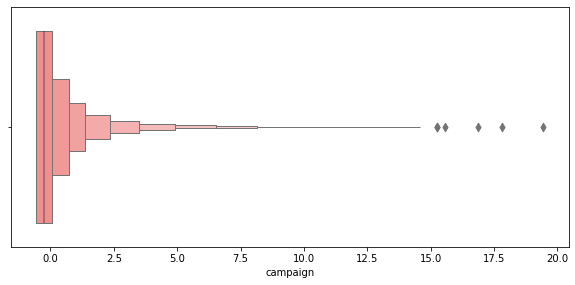

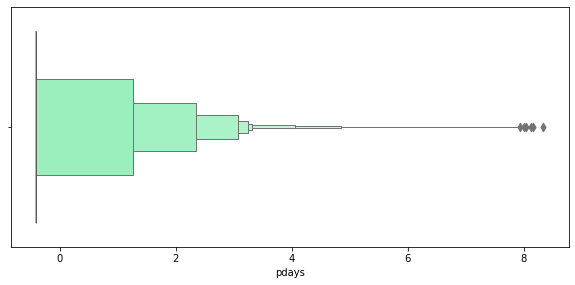

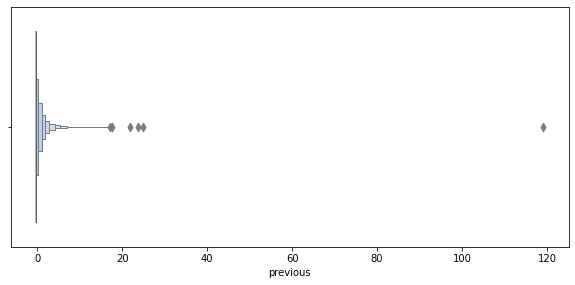

In [217]:
# Columns campaign, pdays and previous have outliers. lets plot the graphs to see the outliers visually.
columns_with_outliers = ['campaign', 'pdays', 'previous']

def plot_outliers():
    palettes = ['spring', 'rainbow', 'pastel']
    plt.rcParams['figure.figsize'] = (10,15)
    for index, col in enumerate(columns_with_outliers):
        plt.subplot(3, 1, index+1)
        sns.boxenplot(bank_data[col], palette=palettes[index])
        plt.show()
plot_outliers()

# Insights

1. We have 18% of the data as outliers for `pdays` and `previous` columns
2. `campaign` columns has outliers of 1.8%

We have significant outliers, we need to treat them because they might cause the model to be overfit and resulting high variance with test data. We will treat the outliers once we split the data in to test and train. As we need to fix the outliers only in train data rather than fixing the whole data set

# Multivariate analysis

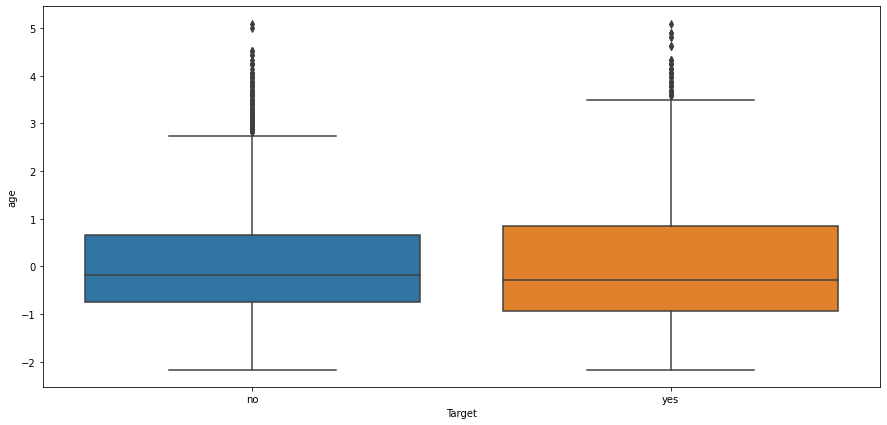

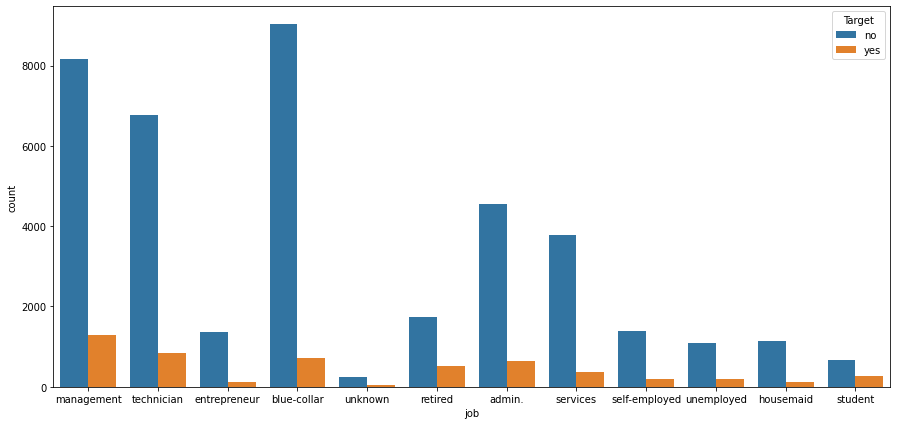

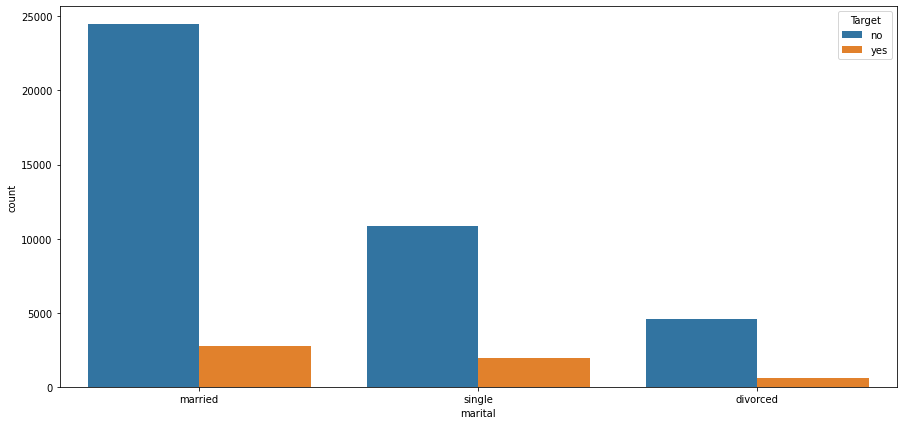

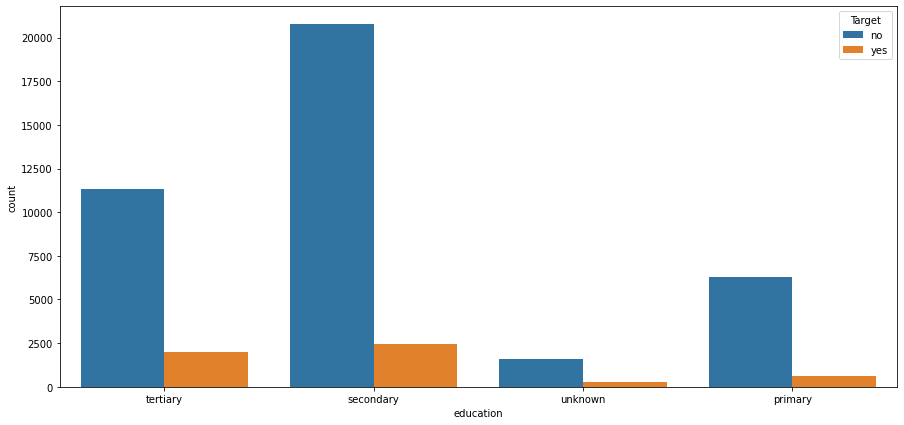

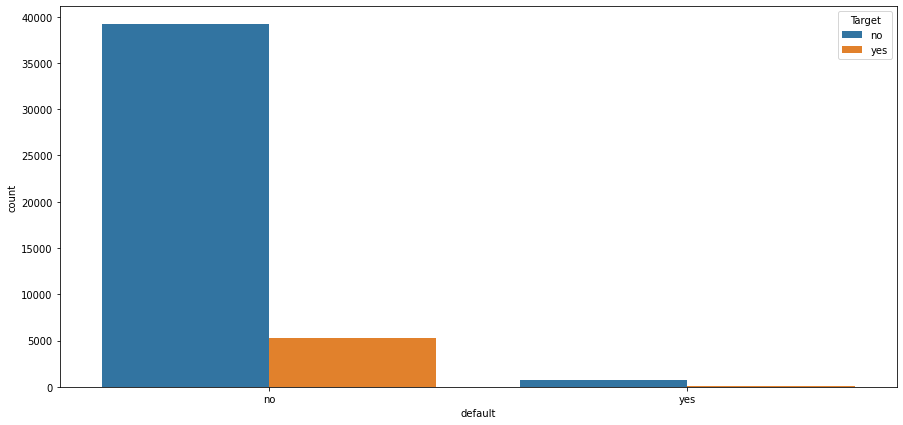

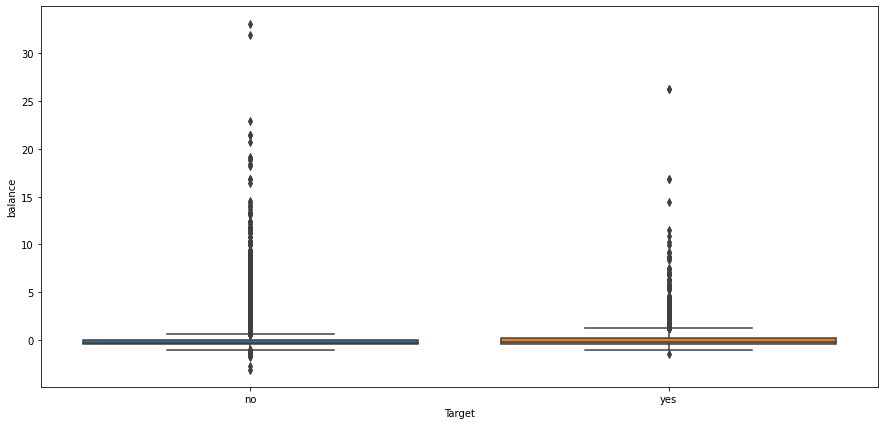

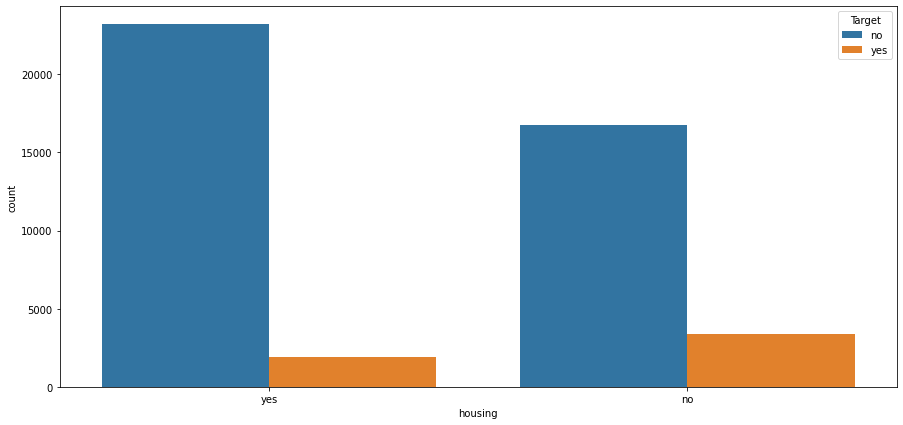

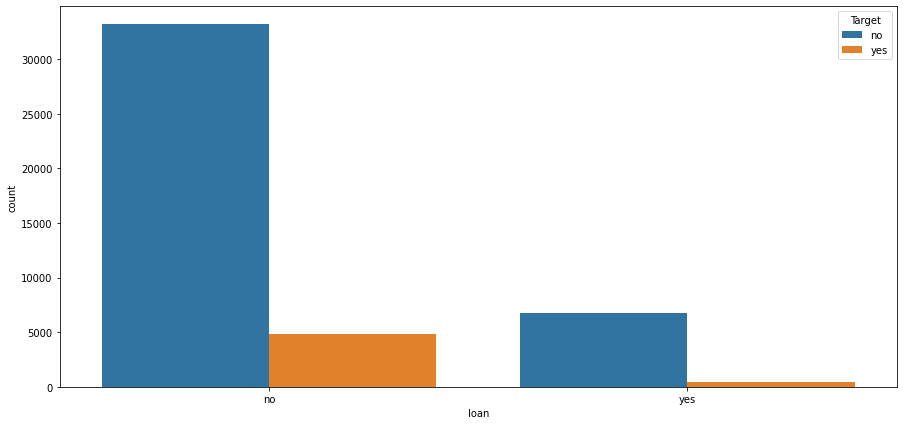

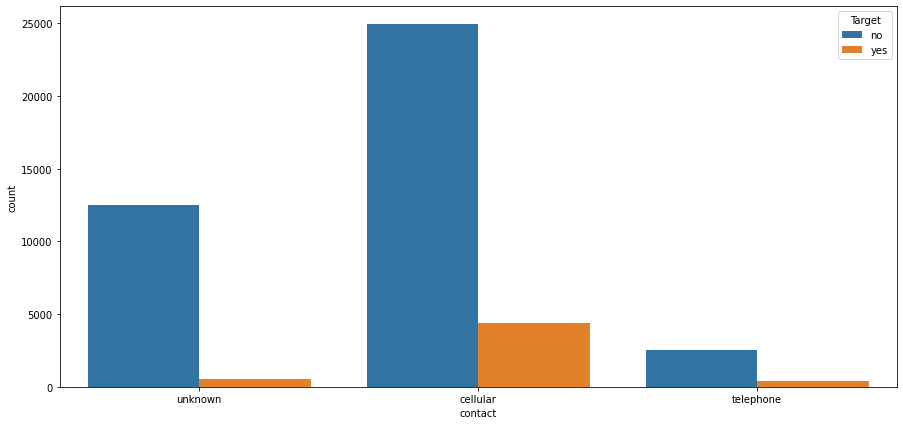

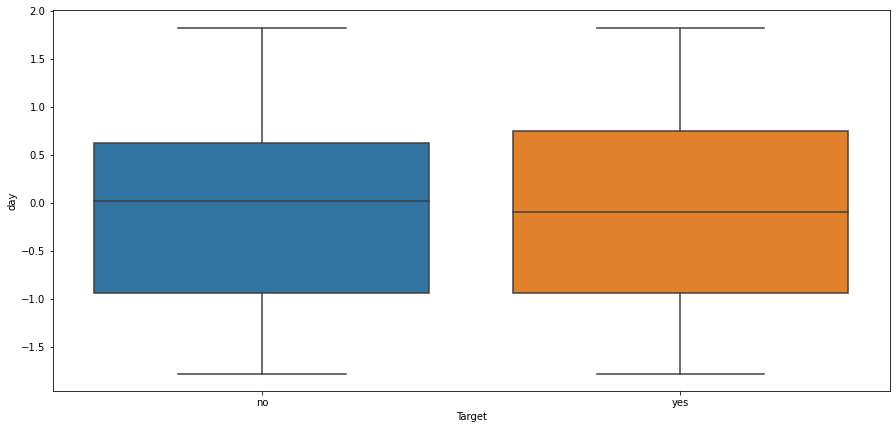

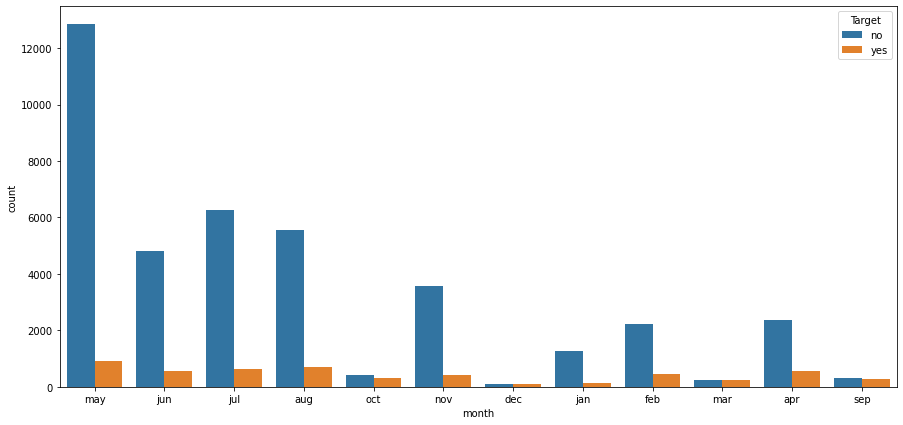

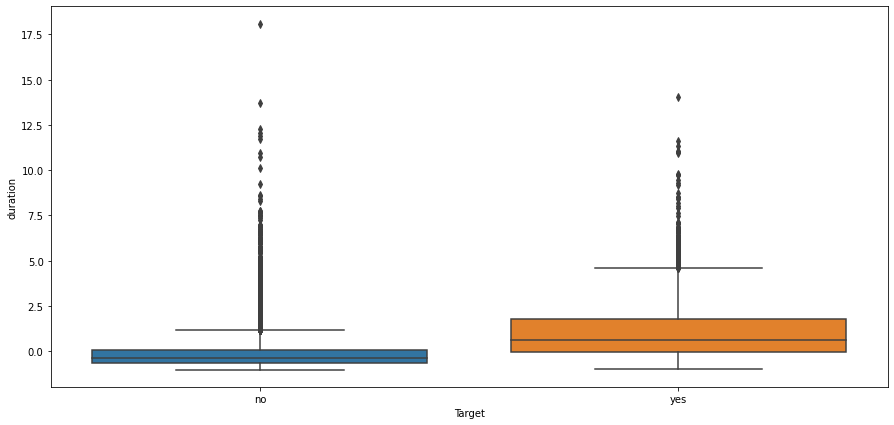

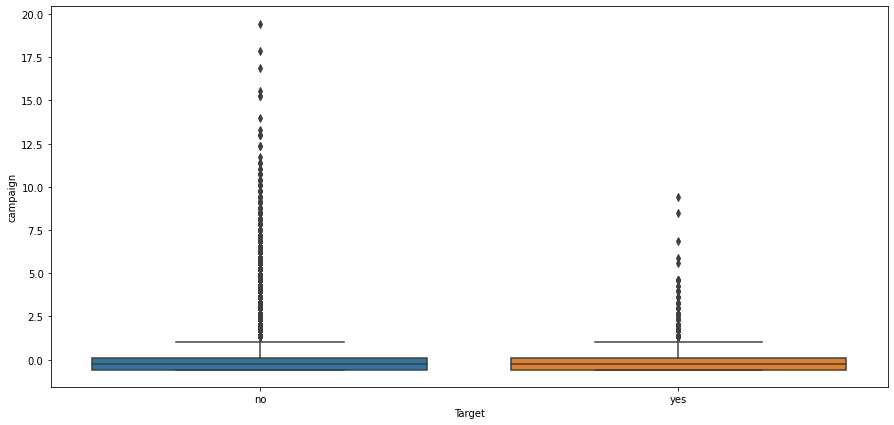

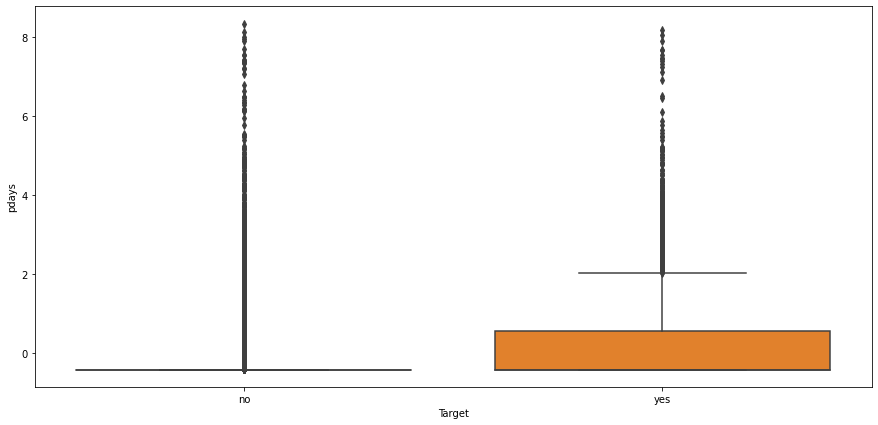

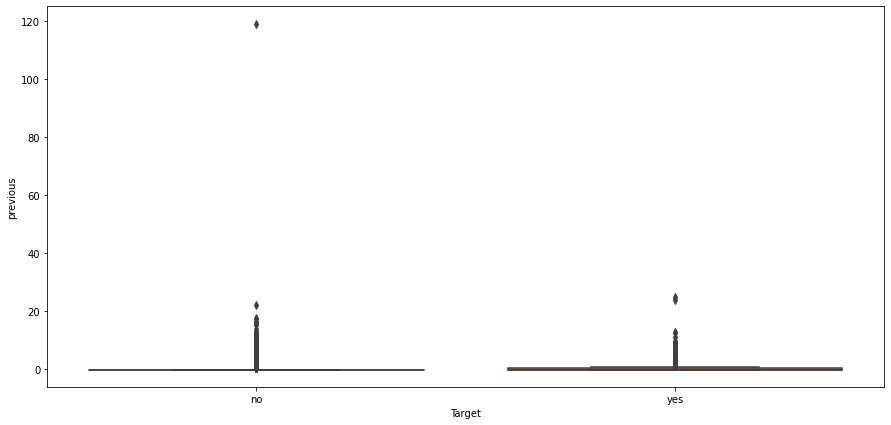

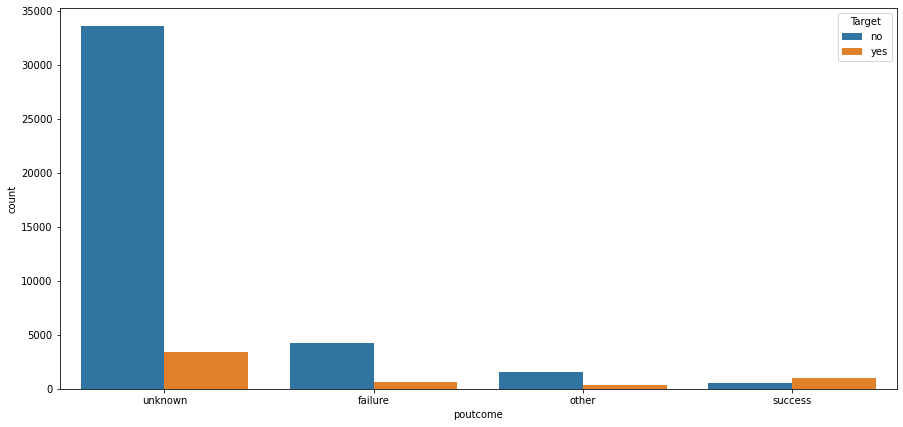

In [218]:
plt.rcParams['figure.figsize'] = (15,7)
def plot_graphs_feature_vs_target(data):
    for col in data.columns:
        if col == 'Target':
            continue
        if col in numerical_columns:
            sns.boxplot(data['Target'], data[col])
        else:
            sns.countplot(data[col], hue=data['Target'])
        plt.show()
plot_graphs_feature_vs_target(bank_data)

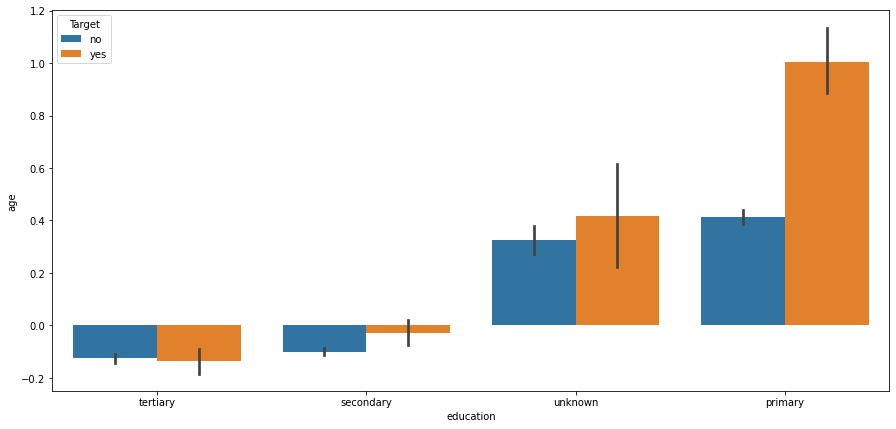

In [219]:
sns.barplot(data=bank_data, x='education', y='age', hue='Target')
plt.show()

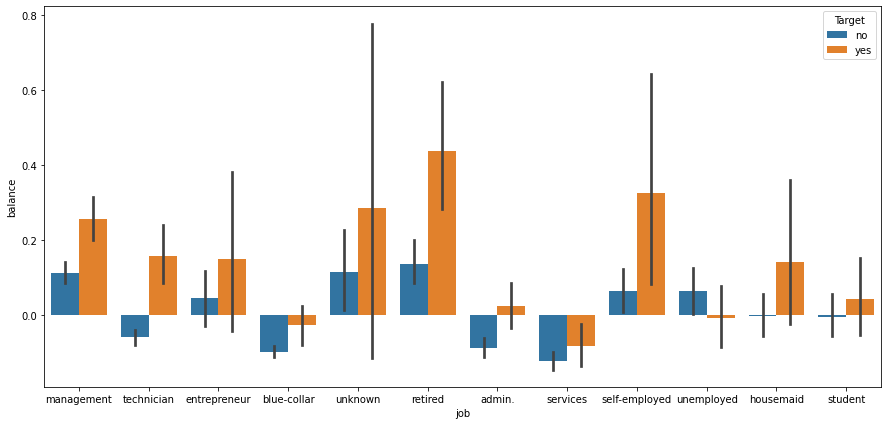

In [220]:
sns.barplot(data=bank_data, x='job', y='balance', hue='Target')
plt.show()

In [221]:
bank_data.groupby('Target').mean()

age   balance       day  duration  campaign     pdays  previous
Target                                                                      
no     -0.009156 -0.019232  0.010318 -0.143599  0.026633 -0.037498 -0.033936
yes     0.069110  0.145167 -0.077882  1.083901 -0.201032  0.283041  0.256154

In [222]:
mapping = {'no':0, 'yes':1}
bank_data['Target'] = bank_data['Target'].replace(mapping) 
bank_data['Target'].astype('int64')
bank_data['Target']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: Target, Length: 45211, dtype: int64

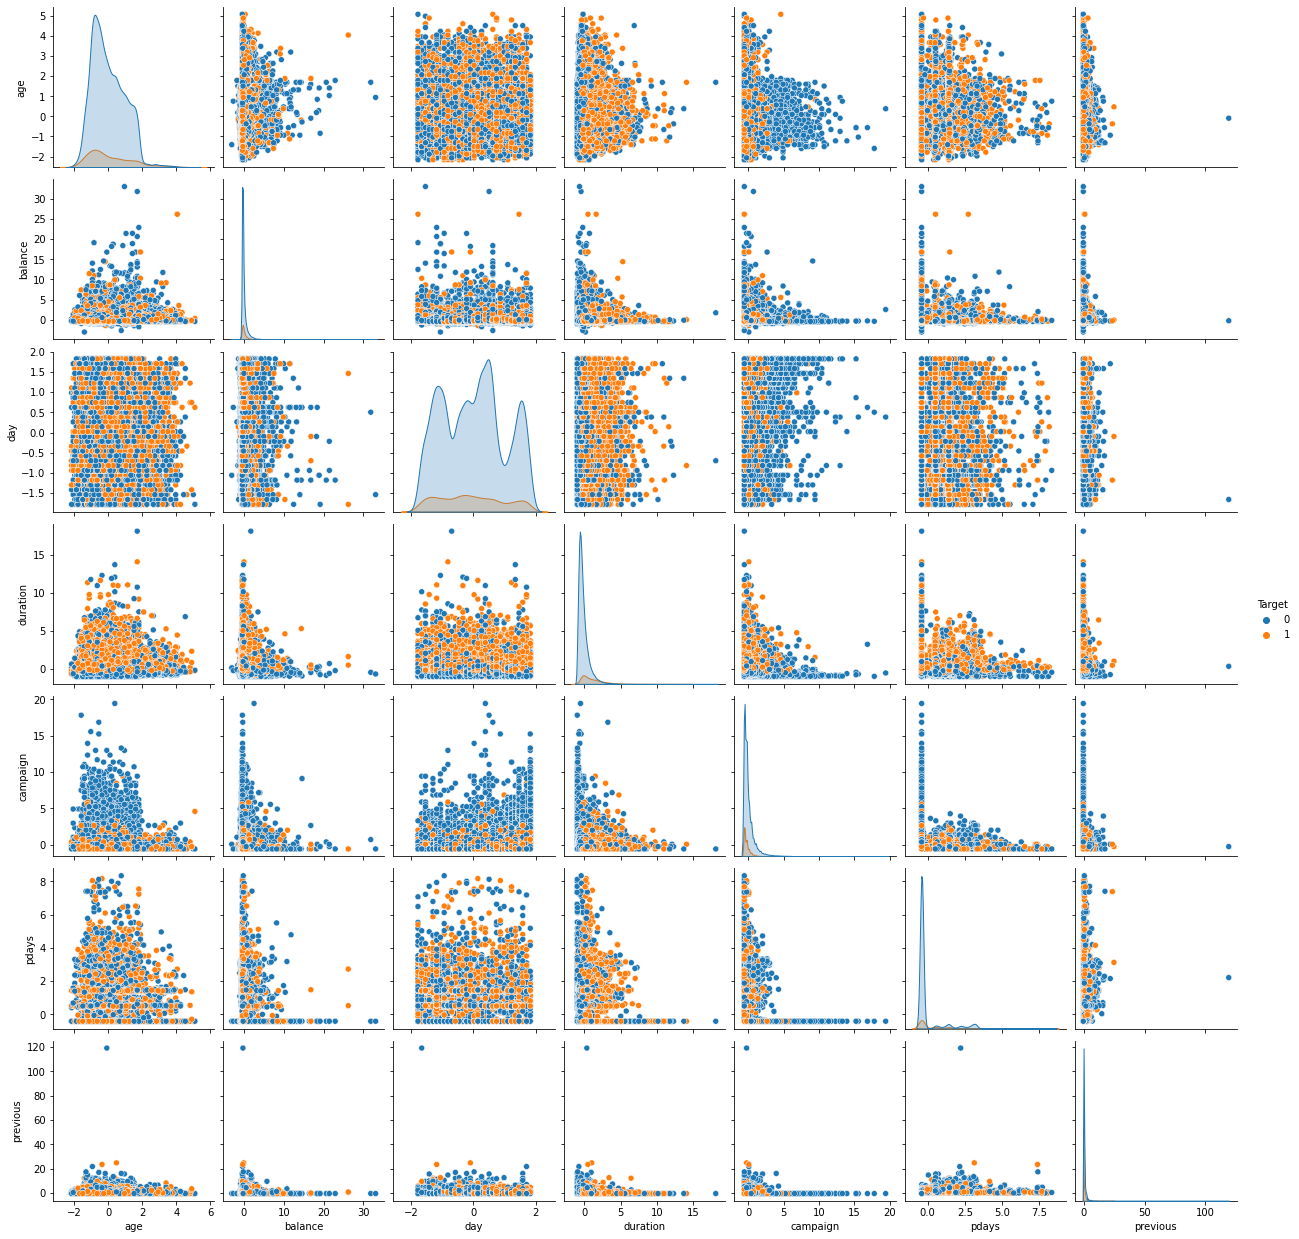

In [25]:
sns.pairplot(bank_data, hue='Target')
plt.show()

<AxesSubplot:>

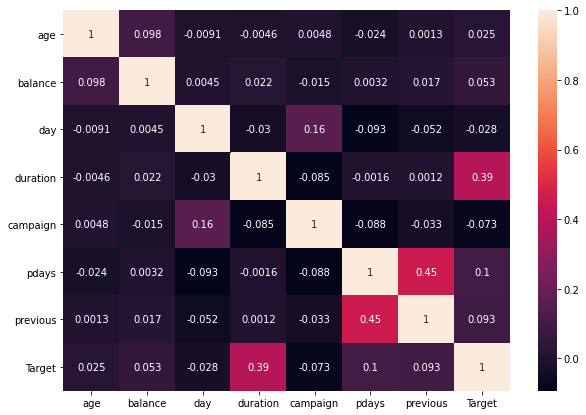

In [26]:
plt.figure(figsize=(10,7))
sns.heatmap(bank_data.corr(), annot=True)

`There is not much co relation between features and target variable as well as relation among features`

# Data Preparation

I am going to create dummy variables for all the category variables instead of using label encoding. Because label encoding will convert the categorical values in to numerical values.  For example: The values of <b>contact</b> column can be label encoded as <b>1 for cellular, 2 for telephone and 3 for unknown</b>. Which will cause model to misinterpret that there exists an order among the values but they are just categorical values with no relation between them.



In [268]:
numerical_columns, categorical_columns = get_categorical_and_numerical_columns()
bank_data = pd.get_dummies(bank_data, columns=categorical_columns)
bank_data.head()

age   balance       day  duration  campaign    pdays  previous  \
0  1.606965  0.256419 -1.298476  0.011016 -0.569351 -0.41056  -0.25194   
1  0.288529 -0.437895 -1.298476 -0.416127 -0.569351 -0.41056  -0.25194   
2 -0.747384 -0.446762 -1.298476 -0.707361 -0.569351 -0.41056  -0.25194   
3  0.571051  0.047205 -1.298476 -0.645231 -0.569351 -0.41056  -0.25194   
4 -0.747384 -0.447091 -1.298476 -0.233620 -0.569351 -0.41056  -0.25194   

   Target  contact_telephone  contact_unknown  ...  month_jan  month_jul  \
0       0                  0                1  ...          0          0   
1       0                  0                1  ...          0          0   
2       0                  0                1  ...          0          0   
3       0                  0                1  ...          0          0   
4       0                  0                1  ...          0          0   

   month_jun  month_mar  month_may  month_nov  month_oct  month_sep  \
0          0          0          1          0          0          0   
1          0          0          1          0          0          0   
2          0          0          1          0          0          0   
3          0          0          1          0          0          0   
4          0          0          1          0          0          0   

   marital_married  marital_single  
0                1               0  
1                0               1  
2                1               0  
3                1               0  
4                0               1  

[5 rows x 43 columns]

In [269]:
# Splitting the data into train and test with 70:30 ratio using a random_state = 7
X = bank_data.drop('Target', axis=1)
y = bank_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=7)

In [270]:
def find_percent_of_class_dist(data, col):
    if isinstance(data, pd.DataFrame):
        no_percentage = (len(data[data[col]==0])/len(data))*100
        yes_percentage = (len(data[data[col]==1])/len(data))*100
    else:
        no_percentage = (len(data[data==0])/len(data))*100
        yes_percentage = (len(data[data==1])/len(data))*100
    return no_percentage, yes_percentage
no_percentage, yes_percentage = find_percent_of_class_dist(bank_data, 'Target')
print('the percentage of no: {} and yes: {} values in the whole data set'.format(no_percentage, yes_percentage))
no_percentage, yes_percentage = find_percent_of_class_dist(y_train, None)
print('the percentage of no: {} and yes: {} values in the train data set'.format(no_percentage, yes_percentage ))
no_percentage, yes_percentage = find_percent_of_class_dist(y_test, None)
print('the percentage of no: {} and yes: {} values in the test data set'.format(no_percentage, yes_percentage ))


the percentage of no: 88.30151954170445 and yes: 11.698480458295547 values in the whole data set
the percentage of no: 88.1347363099188 and yes: 11.865263690081209 values in the train data set
the percentage of no: 88.69065172515482 and yes: 11.309348274845178 values in the test data set


`We can say the class distribution is same among the whole data set, train and test data sets`

In [271]:
outliers_in_train_data = get_outliers(X_train)
outliers_in_train_data

age                       0
balance                   0
campaign                591
contact_telephone         0
contact_unknown           0
day                       0
default_yes               0
duration                  0
education_secondary       0
education_tertiary        0
education_unknown         0
housing_yes               0
job_blue-collar           0
job_entrepreneur          0
job_housemaid             0
job_management            0
job_retired               0
job_self-employed         0
job_services              0
job_student               0
job_technician            0
job_unemployed            0
job_unknown               0
loan_yes                  0
marital_married           0
marital_single            0
month_aug                 0
month_dec                 0
month_feb                 0
month_jan                 0
month_jul                 0
month_jun                 0
month_mar                 0
month_may                 0
month_nov                 0
month_oct           

In [272]:
# Now that we split the data into train and test, lets fix the outliers in training data before fitting the model
for col in columns_with_outliers:
    q1 = X_train[col].quantile(0.25)
    q3 = X_train[col].quantile(0.75)
    iqr = q3 - q1
    upper_wisker = q3 + 1.5 * iqr
    lower_wisker = q1 - 1.5 * iqr
    #Replace the lower-end outliers with lower wisker
    X_train[col] = np.where(X_train[col] < lower_wisker, lower_wisker, X_train[col])
    
     #Replace the upper-end outliers with upper wisker
    X_train[col] = np.where(X_train[col] > upper_wisker, upper_wisker, X_train[col])

In [273]:
outliers_in_train_data_after_capping = get_outliers(X_train)
outliers_in_train_data_after_capping

age                    0
balance                0
campaign               0
contact_telephone      0
contact_unknown        0
day                    0
default_yes            0
duration               0
education_secondary    0
education_tertiary     0
education_unknown      0
housing_yes            0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
loan_yes               0
marital_married        0
marital_single         0
month_aug              0
month_dec              0
month_feb              0
month_jan              0
month_jul              0
month_jun              0
month_mar              0
month_may              0
month_nov              0
month_oct              0
month_sep              0
pdays                  0
poutcome_other         0
poutcome_success       0


# Model Creation

# Decision Tree

In [274]:
dTree = DecisionTreeClassifier(criterion='gini', random_state=7)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=7)

In [275]:
print('Train score of Decision tree: {}'. format(dTree.score(X_train, y_train)))
print('Test score of Decision tree: {}'. format(dTree.score(X_test, y_test)))

Train score of Decision tree: 1.0
Test score of Decision tree: 0.8734886464169861


In [276]:
#visualize the tree
def plot_tree_graph(dTree):
    bank_data_tree = open('bank_data_tree.dot','w')
    bank_data_dot = tree.export_graphviz(dTree, out_file=bank_data_tree, feature_names=X_train.columns)
    bank_data_tree.close()
    with open("bank_data_tree.dot") as f:
        dot_graph = f.read()
    display(graphviz.Source(dot_graph))
plot_tree_graph(dTree)

In [277]:
# The tree is overfit with training data, so lets prune the tree to avoid overfit
dTree_pruned = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=50, random_state=7)
dTree_pruned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, random_state=7)

In [278]:
print('Train score of pruned Decision tree: {}'. format(dTree_pruned.score(X_train, y_train)))
print('Test score of pruned Decision tree: {}'. format(dTree_pruned.score(X_test, y_test)))

Train score of pruned Decision tree: 0.9010648718677916
Test score of pruned Decision tree: 0.9027572987319374


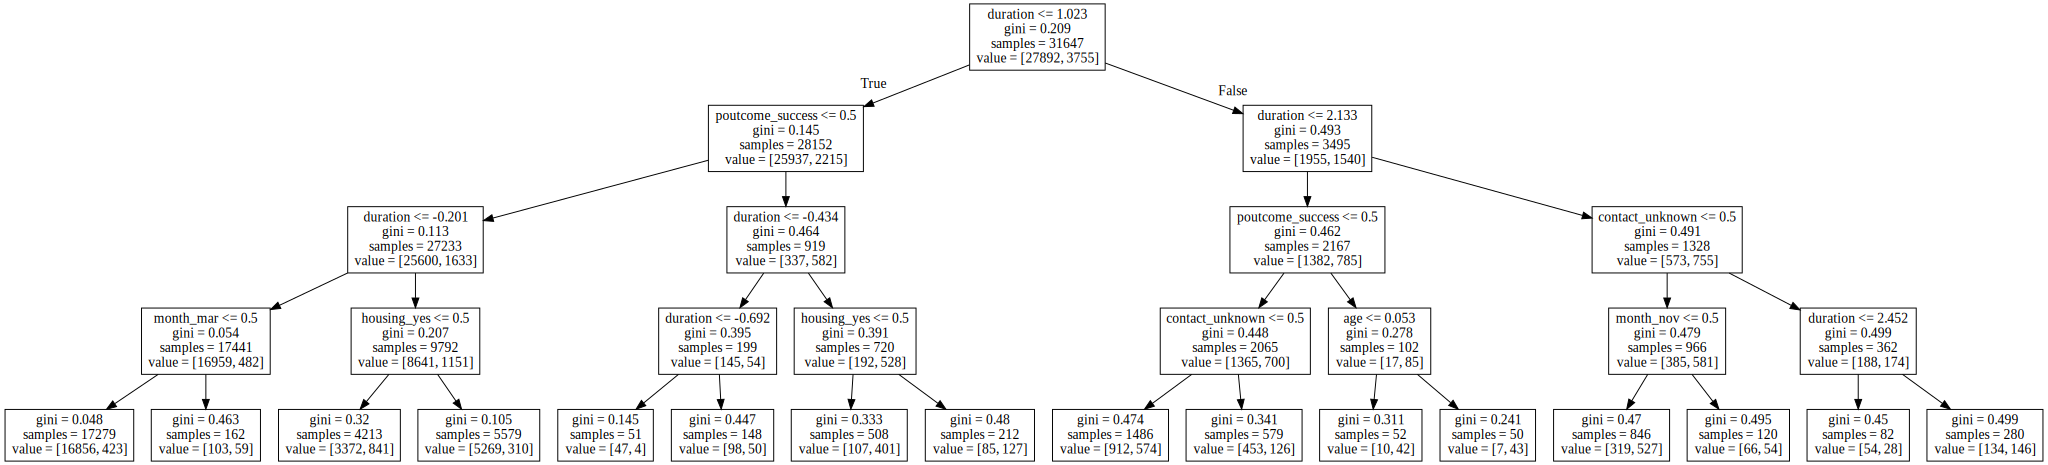

In [279]:
plot_tree_graph(dTree_pruned)

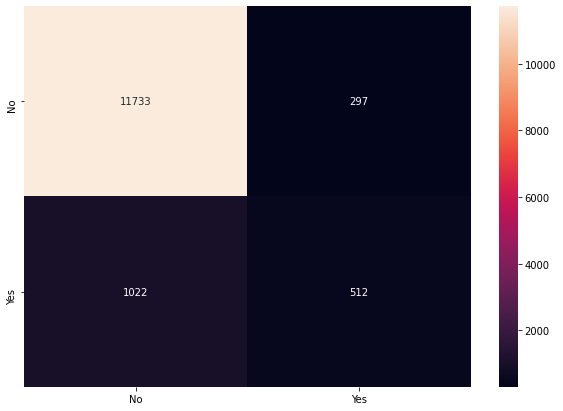

In [280]:
y_predict = dTree_pruned.predict(X_test)
def plot_confusion_matrix(y_test, y_predict):
    conf_matrix = confusion_matrix(y_test, y_predict)

    df_cm = pd.DataFrame(conf_matrix, index = [i for i in ["No","Yes"]],
                      columns = [i for i in ["No","Yes"]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True ,fmt='g')
    plt.show()

plot_confusion_matrix(y_test, y_predict)

In [281]:
def calculate_conf_matrix_values(y_test, y_predict):
    tp, fp, fn, tn = 0,0,0,0
    y_test_array = y_test.to_numpy()
    for i in range(len(y_test)):
        if (y_test.iloc[i] == 1 and y_predict[i] == 1):
            tp+=1
        elif (y_test.iloc[i] == 0 and y_predict[i] == 1):
            fp+=1
        elif (y_test.iloc[i] == 1 and y_predict[i] == 0):
            fn+=1
        else:
            tn+=1
    return tp, fp, fn, tn
tp, fp, fn, tn = calculate_conf_matrix_values(y_test, y_predict)
print('TP: {}'.format(tp)+' FP: {}'.format(fp)+ ' FN: {}'.format(fn)+ ' TN: {}'.format(tn))

TP: 512 FP: 297 FN: 1022 TN: 11733


In [282]:
result_df = pd.DataFrame(columns=['train_score', 'test_score', 'precision', 'recall'])
def update_result_df(train_score, y_test, y_predict, method_name):
    result_df.loc[method_name] = [train_score, accuracy_score(y_test, y_predict), precision_score(y_test, y_predict), recall_score(y_test, y_predict)]
    return result_df
result_df = update_result_df(dTree_pruned.score(X_train, y_train), y_test, y_predict, 'Decision Tree')
result_df.head()

train_score  test_score  precision    recall
Decision Tree     0.901065    0.902757    0.63288  0.333768

In [283]:
print('Decision Tree class level metrics:')
print(classification_report(y_test, y_predict))

Decision Tree class level metrics:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     12030
           1       0.63      0.33      0.44      1534

    accuracy                           0.90     13564
   macro avg       0.78      0.65      0.69     13564
weighted avg       0.89      0.90      0.89     13564



# Bagging Classifier

In [284]:
bagging_classifier = BaggingClassifier(base_estimator=dTree, n_estimators=25, random_state=7)
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=7),
                  n_estimators=25, random_state=7)

In [285]:
print('Train score of Bagging Classifier: {}'. format(bagging_classifier.score(X_train, y_train)))
print('Test score of Bagging Classifier: {}'. format(bagging_classifier.score(X_test, y_test)))

Train score of Bagging Classifier: 0.9989888457041741
Test score of Bagging Classifier: 0.9023149513417871


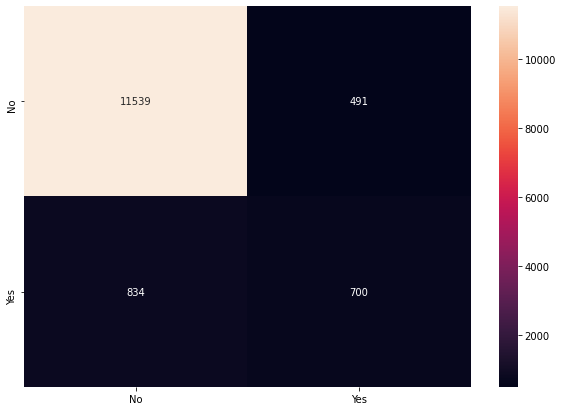

In [286]:
y_predict = bagging_classifier.predict(X_test)

plot_confusion_matrix(y_test, y_predict)

In [287]:
result_df = update_result_df(bagging_classifier.score(X_train, y_train), y_test, y_predict, 'Bagging Classifier')
result_df.head()

train_score  test_score  precision    recall
Decision Tree          0.901065    0.902757   0.632880  0.333768
Bagging Classifier     0.998989    0.902315   0.587741  0.456323

In [288]:
print('Bagging classifier class level metrics:')
print(classification_report(y_test, y_predict))

Bagging classifier class level metrics:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     12030
           1       0.59      0.46      0.51      1534

    accuracy                           0.90     13564
   macro avg       0.76      0.71      0.73     13564
weighted avg       0.89      0.90      0.90     13564



# AdaBoost Classifier

In [289]:
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=7)
adaboost_classifier.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=7)

In [290]:
print('Train score of AdaBoost Classifier: {}'. format(adaboost_classifier.score(X_train, y_train)))
print('Test score of AdaBoost Classifier: {}'. format(adaboost_classifier.score(X_test, y_test)))

Train score of AdaBoost Classifier: 0.9006224918633677
Test score of AdaBoost Classifier: 0.9041580654674137


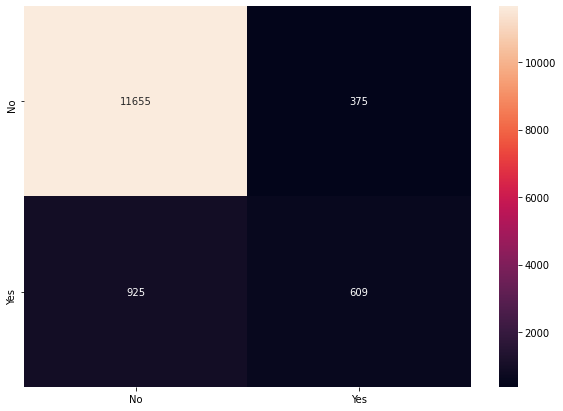

In [291]:
y_predict = adaboost_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_predict)

In [292]:
result_df = update_result_df(adaboost_classifier.score(X_train, y_train), y_test, y_predict, 'AdaBoost Classifier')
result_df.head()

train_score  test_score  precision    recall
Decision Tree           0.901065    0.902757   0.632880  0.333768
Bagging Classifier      0.998989    0.902315   0.587741  0.456323
AdaBoost Classifier     0.900622    0.904158   0.618902  0.397001

In [293]:
print('AdaBoost Classifier class level metrics:')
print(classification_report(y_test, y_predict))

AdaBoost Classifier class level metrics:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12030
           1       0.62      0.40      0.48      1534

    accuracy                           0.90     13564
   macro avg       0.77      0.68      0.72     13564
weighted avg       0.89      0.90      0.89     13564



# GradientBoost Classifier

In [294]:
gradientboost_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.3, random_state=7)
gradientboost_classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, random_state=7)

In [295]:
print('Train score of Gradientboost Classifier: {}'. format(gradientboost_classifier.score(X_train, y_train)))
print('Test score of Gradientboost Classifier: {}'. format(gradientboost_classifier.score(X_test, y_test)))

Train score of Gradientboost Classifier: 0.9204663949189497
Test score of Gradientboost Classifier: 0.9102772043644942


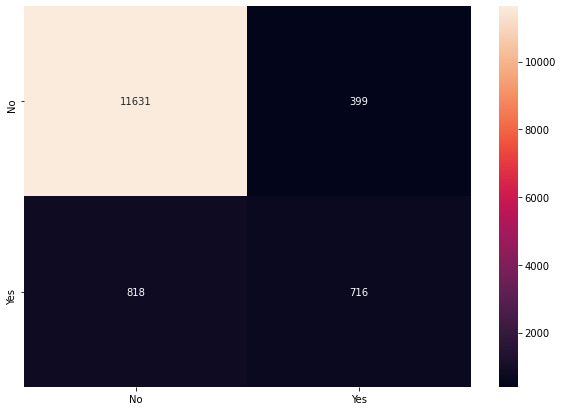

In [296]:
y_predict = gradientboost_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_predict)

In [297]:
result_df = update_result_df(gradientboost_classifier.score(X_train, y_train), y_test, y_predict, 'GradientBoost Classifier')
result_df.head()

train_score  test_score  precision    recall
Decision Tree                0.901065    0.902757   0.632880  0.333768
Bagging Classifier           0.998989    0.902315   0.587741  0.456323
AdaBoost Classifier          0.900622    0.904158   0.618902  0.397001
GradientBoost Classifier     0.920466    0.910277   0.642152  0.466754

In [298]:
print('GradientBoost Classifier class level metrics:')
print(classification_report(y_test, y_predict))

GradientBoost Classifier class level metrics:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12030
           1       0.64      0.47      0.54      1534

    accuracy                           0.91     13564
   macro avg       0.79      0.72      0.75     13564
weighted avg       0.90      0.91      0.90     13564



# RandomForest Classifier

In [299]:
randomforest_classifier = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=7)
randomforest_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=7)

In [300]:
print('Train score of RandomForest Classifier: {}'. format(randomforest_classifier.score(X_train, y_train)))
print('Test score of RandomForest Classifier: {}'. format(randomforest_classifier.score(X_test, y_test)))

Train score of RandomForest Classifier: 0.9999684014282555
Test score of RandomForest Classifier: 0.9072544971984665


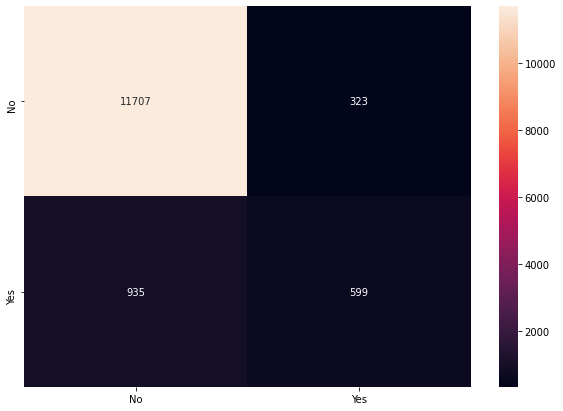

In [301]:
y_predict = randomforest_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_predict)

In [302]:
result_df = update_result_df(randomforest_classifier.score(X_train, y_train), y_test, y_predict, 'RandomForest Classifier')
result_df.head()

train_score  test_score  precision    recall
Decision Tree                0.901065    0.902757   0.632880  0.333768
Bagging Classifier           0.998989    0.902315   0.587741  0.456323
AdaBoost Classifier          0.900622    0.904158   0.618902  0.397001
GradientBoost Classifier     0.920466    0.910277   0.642152  0.466754
RandomForest Classifier      0.999968    0.907254   0.649675  0.390482

In [303]:
print('RandomForest Classifier class level metrics:')
print(classification_report(y_test, y_predict))

RandomForest Classifier class level metrics:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12030
           1       0.65      0.39      0.49      1534

    accuracy                           0.91     13564
   macro avg       0.79      0.68      0.72     13564
weighted avg       0.89      0.91      0.90     13564



# Confusion Matrix Metrics:

<ol>
    <li><b> Precision</b> - It tells that out of  total number of True predictions by the model, what fraction of them are actually true. 
        <b><i>Precision = TP/(TP+FP)</i></b></li>
    <li><b> Recall</b> - It tells that out of total number of Actual True labels, what fraction of them the model predicted true. 
        <b><i>Recall = TP/(TP+FN)</i></b></li>
</ol>

<p>The objective of the project is to help the marketing team identify potential customers who are relatively more likely to subscribe to the term deposit and this increase the hit ratio.</p>

<p>For our objective, if the model predicts that a customer will subscribe for term deposit and the customer ended up not subscribing is less costly compared to the model predicted that a customer is not going to subscribe but ended up subscribing for Term Deposit.</p>

<p>Having more False Negatives will be constly for the bank. So we need to reduce Fallse Negatives. Since Recall deals with False Negatives, we need to look at <b><i>Recall</i></b> metric while evaluting the model performance.</p>


# Among all the five models above, The Gradient Boost Classifier gives the best recall, its not overfit with train data.  So we will choose <b><i><u>GradientBoost Classifier model</u></i></b>

# What do you mean by recall and what information does it provide here?

Recall gives the fraction of predictions that are correctly classified by the model.

It gives a measure of how accurately the model is able to identify the relavant class in our case, Term Deposit Subscription

In [304]:
pd.DataFrame(gradientboost_classifier.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

importance
duration               0.445871
poutcome_success       0.158396
day                    0.045181
housing_yes            0.040202
age                    0.040128
contact_unknown        0.039408
month_mar              0.033957
poutcome_unknown       0.030925
month_jun              0.024844
balance                0.023783
month_oct              0.019569
month_sep              0.018239
month_feb              0.014323
month_nov              0.011447
campaign               0.009558
month_dec              0.004891
month_jan              0.004252
month_jul              0.004090
job_student            0.003248
marital_married        0.002800
education_tertiary     0.002771
poutcome_other         0.002760
month_aug              0.002415
marital_single         0.002250
loan_yes               0.002248
month_may              0.001998
job_entrepreneur       0.001710
job_services           0.001547
job_blue-collar        0.001110
job_unemployed         0.000920
job_management         0.000896
education_secondary    0.000890
job_unknown            0.000874
education_unknown      0.000845
job_technician         0.000689
contact_telephone      0.000562
job_self-employed      0.000266
job_housemaid          0.000133
default_yes            0.000000
job_retired            0.000000
previous               0.000000
pdays                  0.000000

# Suggest some changes for the organization so that they can increase the number of customers who take term deposit.

# How much influence does the previous campaign and mode of interaction have on financial performance?

It seems that the previous campaign and mode of contact has no impact on the current objective.

# Which features should be more/less focused by the bank to get better results and why?

balance and duration have significant impact on the target variable and bank should focus more on these while targetting customers for term deposit subscription. Other features doesn't seems to have much impact on the target variable

# What did you learn about banking industries from this data?